In [45]:
import os
import json
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import torch
from ultralytics import YOLO
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch версия: 2.6.0+cpu
CUDA: False


Загружаем аннотации...
Загружено 7988 изображений
Загружено 38642 аннотаций
Категорий объектов: 8

📋 Категории объектов:
  ID 2140001: vibration_damper
  ID 2150001: festoon_insulators
  ID 2280011: polymer_insulators
  ID 2160001: traverse
  ID 2220001: nest
  ID 2280000: bad_insulator
  ID 2280001: damaged_insulator
  ID 2270001: safety_sign+


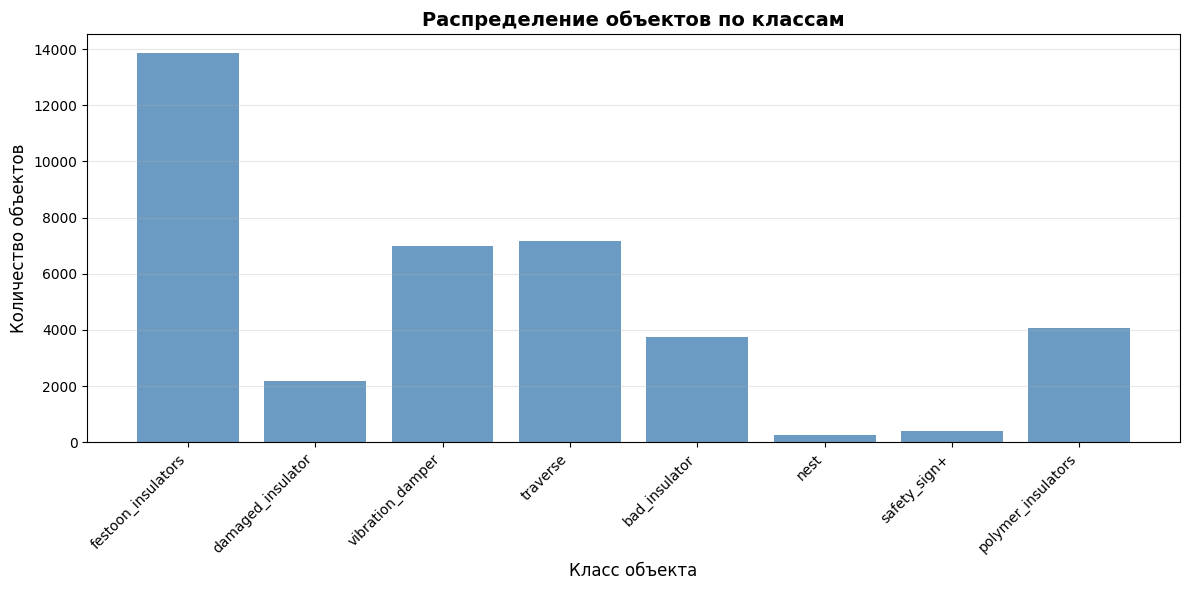


Статистика по классам:
  festoon_insulators: 13846 объектов
  traverse: 7151 объектов
  vibration_damper: 6969 объектов
  polymer_insulators: 4061 объектов
  bad_insulator: 3753 объектов
  damaged_insulator: 2184 объектов
  safety_sign+: 414 объектов
  nest: 264 объектов


In [46]:
DATA_DIR = Path("insulators")
IMAGES_DIR = DATA_DIR / "images"
ANNOTATIONS_FILE = DATA_DIR / "annotation_data.json"
CATEGORIES_FILE = DATA_DIR / "coco_categories.json"

# Загружаем JSON файлы
print("Загружаем аннотации...")
with open(ANNOTATIONS_FILE, 'r', encoding='utf-8') as f:
    annotations_data = json.load(f)

with open(CATEGORIES_FILE, 'r', encoding='utf-8') as f:
    categories_data = json.load(f)

print(f"Загружено {len(annotations_data.get('images', []))} изображений")
print(f"Загружено {len(annotations_data.get('annotations', []))} аннотаций")
print(f"Категорий объектов: {len(categories_data.get('categories', []))}")

# Создаем словарь категорий (id -> название)
categories = {cat['id']: cat['name'] for cat in categories_data['categories']}
print("\n📋 Категории объектов:")
for cat_id, cat_name in categories.items():
    print(f"  ID {cat_id}: {cat_name}")

# Подсчитываем количество объектов каждого класса
category_counts = {}
for ann in annotations_data['annotations']:
    cat_id = ann['category_id']
    cat_name = categories[cat_id]
    category_counts[cat_name] = category_counts.get(cat_name, 0) + 1

# Визуализация распределения классов
plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='steelblue', alpha=0.8)
plt.xlabel('Класс объекта', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.title('Распределение объектов по классам', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nСтатистика по классам:")
for cat_name, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cat_name}: {count} объектов")

In [47]:
def coco_to_yolo_bbox(bbox, img_width, img_height):
    """
    Конвертирует bbox из формата COCO в формат YOLO
    
    COCO: [x_min, y_min, width, height] - абсолютные пиксели
    YOLO: [x_center, y_center, width, height] - относительные координаты (0-1)
    
    Пример:
    Изображение 1000x800 пикселей
    COCO bbox: [100, 200, 50, 60]
    YOLO bbox: [0.125, 0.2875, 0.05, 0.075]
    """
    x_min, y_min, width, height = bbox
    
    # Центр объекта
    x_center = x_min + width / 2
    y_center = y_min + height / 2
    
    # Нормализуем к диапазону 0-1
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return [x_center, y_center, width, height]


Структура папок YOLO

In [48]:
YOLO_DIR = Path("insulators_yolo")
YOLO_DIR.mkdir(exist_ok=True)

for split in ['train', 'val']:
    (YOLO_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

print("Done")

Done


Создаем словари для быстрого доступа

In [49]:
#(id -> информация)
images_dict = {img['id']: img for img in annotations_data['images']}

# Группируем аннотации по изображениям
annotations_by_image = {}
for ann in annotations_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_by_image:
        annotations_by_image[img_id] = []
    annotations_by_image[img_id].append(ann)

print(f"Обработано {len(images_dict)} изображений")
print(f"Сгруппировано аннотаций для {len(annotations_by_image)} изображений")

Обработано 7988 изображений
Сгруппировано аннотаций для 7984 изображений


Разделение на train/val 80/20

In [50]:
image_ids = list(images_dict.keys())
np.random.seed(42)  # Для воспроизводимости результатов
np.random.shuffle(image_ids)

split_idx = int(len(image_ids) * 0.8)
train_ids = set(image_ids[:split_idx])
val_ids = set(image_ids[split_idx:])

print(f"📊 Train: {len(train_ids)} изображений")
print(f"📊 Val: {len(val_ids)} изображений")

📊 Train: 6390 изображений
📊 Val: 1598 изображений


In [51]:
print("\n🔍 ДИАГНОСТИКА:")
print(f"📂 Путь к images: {IMAGES_DIR}")
print(f"📂 Существует: {IMAGES_DIR.exists()}")

# Смотрим, что внутри
if IMAGES_DIR.exists():
    subdirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    print(f"\n📁 Найдено подпапок: {len(subdirs)}")
    
    for subdir in subdirs[:3]:  # Показываем первые 3
        files = list(subdir.glob('*'))
        print(f"  - {subdir.name}: {len(files)} файлов")
        if files:
            print(f"    Примеры: {[f.name for f in files[:2]]}")

# Проверяем первые записи в аннотациях
print(f"\n📋 Первые 3 file_name из аннотаций:")
for i, img_info in enumerate(list(images_dict.values())[:3]):
    print(f"  {i+1}. {img_info['file_name']}")


🔍 ДИАГНОСТИКА:
📂 Путь к images: insulators\images
📂 Существует: True

📁 Найдено подпапок: 9
  - BAD INSULATOR DETECTION.V11I.COCO: 397 файлов
    Примеры: ['000000795_jpeg.rf.fdcd7abe4699b8b8a885c984df895841.jpg', '000000986_jpeg.rf.4a0108399c0bb5bc19471755ba4e4148.jpg']
  - BGI_DATASET_YOLOV7_LABEL: 517 файлов
    Примеры: ['su110kv_vo--1-_jpg.rf.26a855303d5a8643ad267391bff1f7f2.jpg', 'su110kv_vo--10-_jpg.rf.17fe8cf4eb4448641565ac4c1f98580f.jpg']
  - festoon_insulators: 430 файлов
    Примеры: ['isols1..JPG', 'isols10..JPG']

📋 Первые 3 file_name из аннотаций:
  1. BAD INSULATOR DETECTION.V11I.COCO/000000795_jpeg.rf.fdcd7abe4699b8b8a885c984df895841.jpg
  2. BAD INSULATOR DETECTION.V11I.COCO/000000986_jpeg.rf.4a0108399c0bb5bc19471755ba4e4148.jpg
  3. BAD INSULATOR DETECTION.V11I.COCO/000001268_JPG.rf.ce5d0b856461fd688829b89438107a6a.jpg


Конвертация и копирование файлов

In [ ]:
# Создаем маппинг категорий COCO -> YOLO (0-indexed)
category_id_to_yolo = {cat_id: idx for idx, cat_id in enumerate(sorted(categories.keys()))}

successful_conversions = 0
failed_conversions = 0
failed_files = []

for img_id, img_info in tqdm(images_dict.items(), desc="Конвертация"):
    # Определяем split
    if img_id in train_ids:
        split = 'train'
    elif img_id in val_ids:
        split = 'val'
    else:
        continue
    
    # Находим файл изображения
    file_name = img_info['file_name']
    
    # Полный путь к исходнику
    source_image_path = IMAGES_DIR / file_name
    
    if not source_image_path.exists():
        failed_conversions += 1
        failed_files.append(file_name)
        continue
    
    # --- Делаем уникальное имя файла, чтобы не было конфликтов ---
    original_name = Path(file_name).name
    dest_image_name = f"{img_id}__{original_name}"   # уникальное имя
    dest_image_path = YOLO_DIR / split / 'images' / dest_image_name

    # копируем только если файла ещё нет
    if not dest_image_path.exists():
        shutil.copy(source_image_path, dest_image_path)
    
    # Создаем .txt файл с аннотациями
    label_file = YOLO_DIR / split / 'labels' / (Path(dest_image_name).stem + '.txt')
    
    img_width = img_info['width']
    img_height = img_info['height']
    
    # Получаем все аннотации
    image_annotations = annotations_by_image.get(img_id, [])
    
    with open(label_file, 'w') as f:
        for ann in image_annotations:
            category_id = ann['category_id']
            yolo_class_id = category_id_to_yolo[category_id]
            
            coco_bbox = ann['bbox']
            yolo_bbox = coco_to_yolo_bbox(coco_bbox, img_width, img_height)
            
            f.write(f"{yolo_class_id} {' '.join(map(str, yolo_bbox))}\n")
    
    successful_conversions += 1

print(f"\n✅ Успешно конвертировано: {successful_conversions} изображений")
print(f"❌ Ошибок: {failed_conversions}")

Конвертация:   1%|▏         | 117/7988 [00:01<02:04, 63.12it/s]

Создаем конфигурационный файл data.yaml

In [ ]:
data_yaml_content = f"""# Конфигурация датасета для детекции объектов на ЛЭП
path: {YOLO_DIR.absolute()}
train: train/images
val: val/images

# Количество классов
nc: {len(categories)}

# Названия классов
names:
"""

# Добавляем названия классов в правильном порядке
for yolo_id in range(len(categories)):
    # Находим соответствующий COCO ID
    coco_id = [k for k, v in category_id_to_yolo.items() if v == yolo_id][0]
    class_name = categories[coco_id]
    data_yaml_content += f"  {yolo_id}: {class_name}\n"

# Сохраняем файл
data_yaml_path = YOLO_DIR / "data.yaml"
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write(data_yaml_content)

print("✅ Создан файл data.yaml")
print("\n📄 Содержимое:")
print(data_yaml_content)

✅ Создан файл data.yaml

📄 Содержимое:
# Конфигурация датасета для детекции объектов на ЛЭП
path: c:\Users\sanek\Desktop\RBX\insulators_yolo
train: train/images
val: val/images

# Количество классов
nc: 8

# Названия классов
names:
  0: vibration_damper
  1: festoon_insulators
  2: traverse
  3: nest
  4: safety_sign+
  5: bad_insulator
  6: damaged_insulator
  7: polymer_insulators



Инициализация YOLOv8

In [ ]:
model = YOLO('yolov8n.pt')  # n = nano (быстрая и легкая версия)

print("Модель YOLOv8n загружена")
print(f"Параметров в модели: ~3.2М")

WARNING Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt... <urlopen error [WinError 10054]      >
✅ Модель YOLOv8n загружена
📊 Параметров в модели: ~3.2М


In [ ]:
# Обучаем модель
results = model.train(
    data=str(data_yaml_path),
    epochs=3,              # Максимум эпох
    imgsz=640,              # Размер изображений
    batch=16,               # Размер батча (уменьши до 8 если не хватает памяти)
    patience=20,            # Останавливаем если нет улучшений 20 эпох
    save=True,              # Сохранять чекпоинты
    device=0 if torch.cuda.is_available() else 'cpu',  # GPU или CPU
    workers=4,              # Количество потоков для загрузки данных
    project='runs/detect',  # Папка для результатов
    name='insulator_detection',
    exist_ok=True,
    
    # Аугментации (искусственное увеличение данных)
    hsv_h=0.015,           # Изменение оттенка
    hsv_s=0.7,             # Изменение насыщенности
    hsv_v=0.4,             # Изменение яркости
    degrees=10,            # Поворот до 10 градусов
    translate=0.1,         # Сдвиг до 10%
    scale=0.5,             # Масштаб ±50%
    flipud=0.0,            # Не переворачивать вертикально
    fliplr=0.5,            # Переворачивать горизонтально в 50% случаев
    mosaic=1.0,            # Мозаичная аугментация
)

Ultralytics 8.3.229  Python-3.13.0 torch-2.6.0+cpu CPU (11th Gen Intel Core i3-1115G4 @ 3.00GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=insulators_yolo\data.yaml, degrees=10, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=insulator_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0

KeyboardInterrupt: 